In [15]:
import air_quality_functions as aqf

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor  
from sklearn.metrics import r2_score, mean_squared_error 

In [2]:
df=pd.read_csv("./data/Train.csv") #for test data no target defined, we treat the "train" data as the whole dataset
#test=pd.read_csv("./data/Test.csv")

In [3]:
features=["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]
df=aqf.convert_str_to_list(df, features)

In [4]:
#train-test split
y = df.target
X = df.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
#impute missing values
X_train=aqf.impute_values(X_train,features,strategy='nearest')
X_test=aqf.impute_values(X_test,features,strategy='nearest')

In [6]:
#drop rows with too many nans
for feature in features:
    y_train.drop(X_train[X_train[feature + '_nans'] >= 30].index, inplace = True)
    X_train.drop(X_train[X_train[feature + '_nans'] >= 30].index, inplace = True)

In [7]:
#drop number_of_non_columns
for feature in features:
    X_train.drop(feature + '_nans',axis=1,inplace=True)
    X_test.drop(feature + '_nans',axis=1,inplace=True)

In [8]:
#add columns with min, max etc
for col_name in features:
    X_train=aqf.aggregate_features(X_train,col_name)
    X_test=aqf.aggregate_features(X_test,col_name)

In [9]:
# #split list in columns into individual columns
# for feat in features:
#     for x in range(121):
#         X_train[feat+ '_'+ str(x)] = X_train[feat].str[x]
# X_train.drop(features,axis=1,inplace=True)

# #split list in columns into individual columns
# for feat in features:
#     for x in range(121):
#         X_test[feat+ '_'+ str(x)] = X_test[feat].str[x]
# X_test.drop(features,axis=1,inplace=True)


In [10]:
#split list in columns making averages across 6 values
for feat in features:
    for x in range(20):
        sum=pd.Series(np.zeros(len(X_train)))
        sum.index=X_train.index
        for j in range(6):
            index=(x*6+j)+1
            sum += X_train[feat].str[index]
        X_train[feat+ '_'+ str(x)] = sum/6
X_train.drop(features,axis=1,inplace=True)

#split list in columns making averages across 6 values
for feat in features:
    for x in range(20):
        sum=pd.Series(np.zeros(len(X_test)))
        sum.index=X_test.index
        for j in range(6):
            index=(x*6+j)+1
            sum += X_test[feat].str[index]
        X_test[feat+ '_'+ str(x)] = sum/6
X_test.drop(features,axis=1,inplace=True)


In [11]:
#drop ID column
X_train.drop('ID',axis=1,inplace=True)
X_test.drop('ID',axis=1,inplace=True)

## Make Baseline Model

In [12]:
#define feature
baseline_features = []
for feat in features:
    baseline_features.append('mean_' + feat)

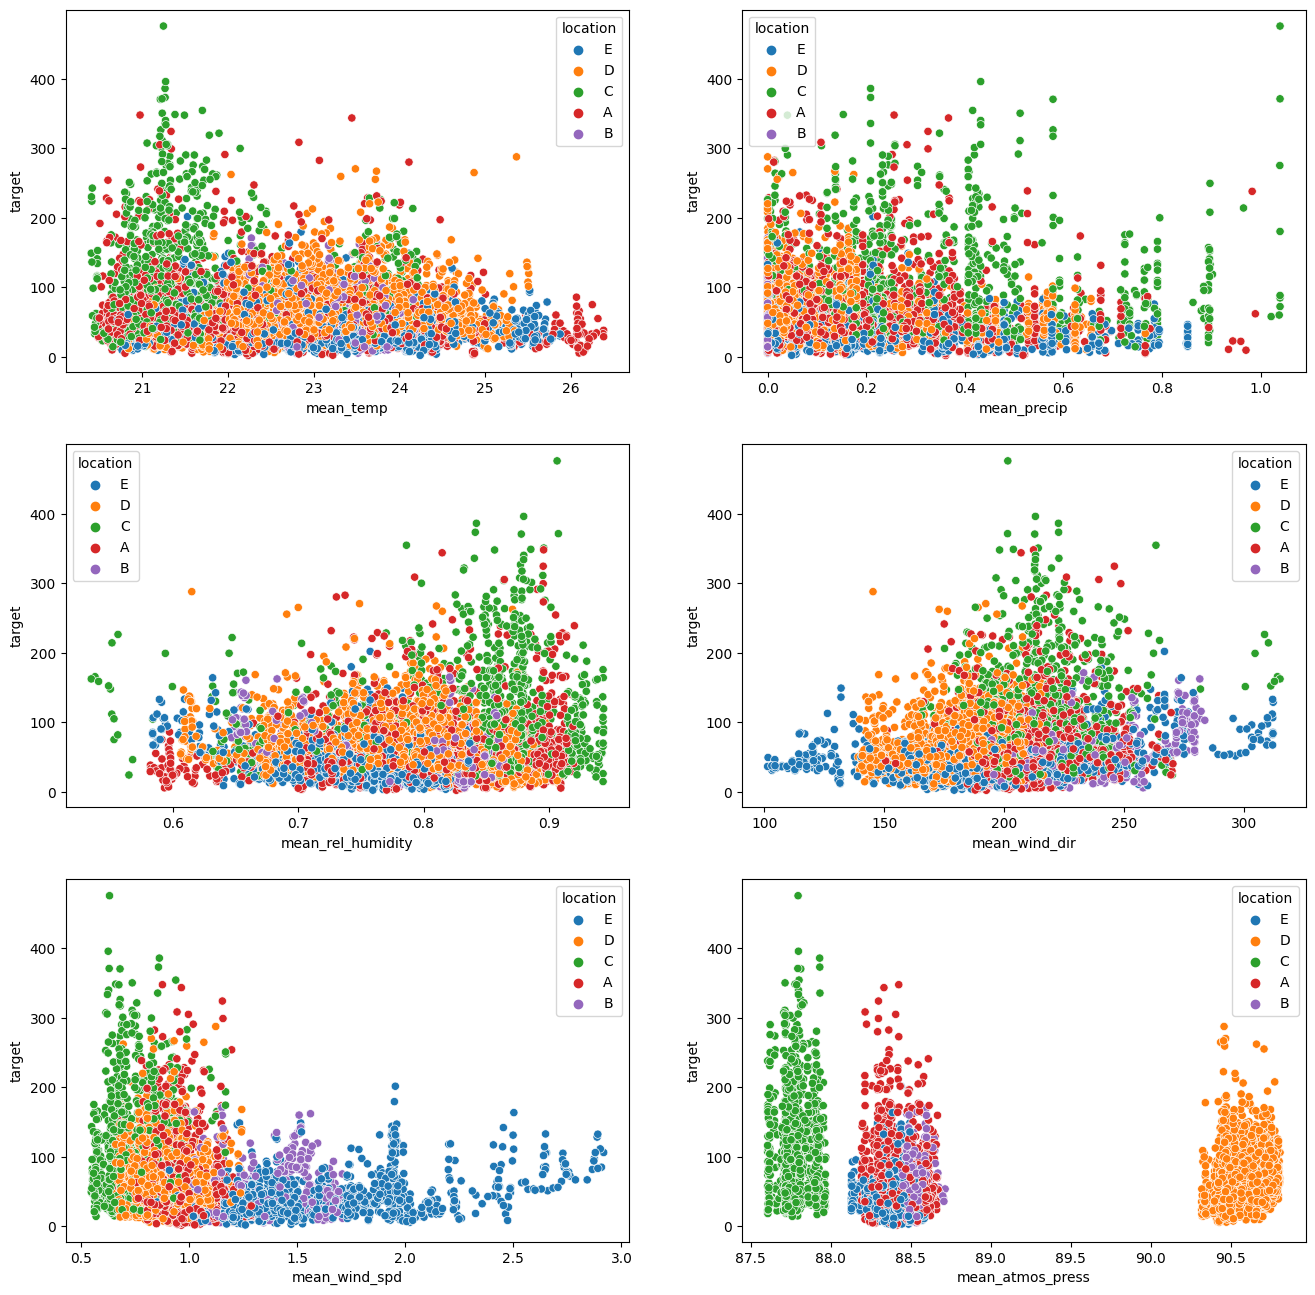

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(3,2,figsize=(16,16))
count=0
for feat in baseline_features:
    sns.scatterplot(x=X_train[feat], y=y_train, hue=X_train.location,
                    ax=ax[int(count/2)][count%2])
    count += 1

In [16]:
#make linear regression with mean of the 6 features
# Instantiate our model 
lin_reg = LinearRegression()

# Train the model using our data
lin_reg.fit(X_train[baseline_features], y_train)

LinearRegression()

In [17]:
#calculate predicted values of the baseline model and r2 score
y_train_pred_base=lin_reg.predict(X_train[baseline_features])
y_test_pred_base=lin_reg.predict(X_test[baseline_features])

y_train_pred_base
r2_score(y_train,y_train_pred_base)


0.11333959071149668

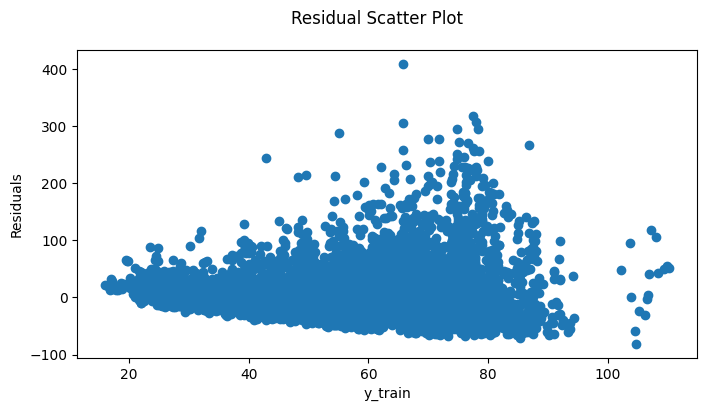

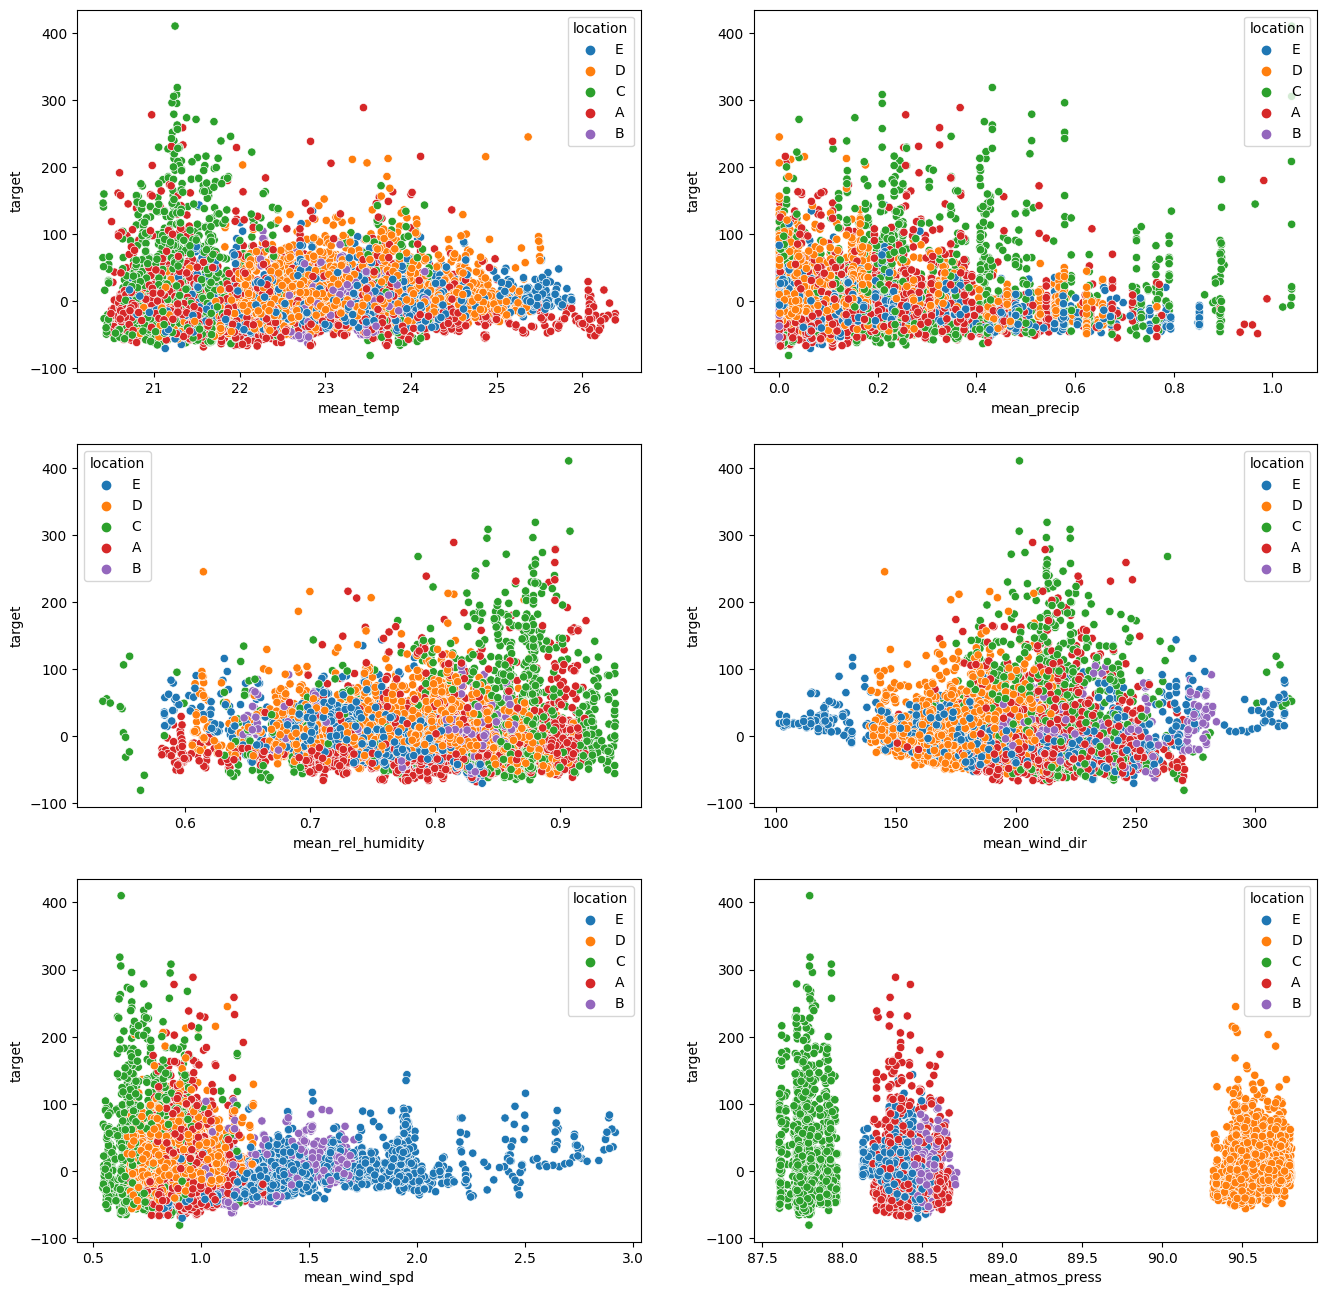

In [18]:
#calculate residuals
residuals=y_train-y_train_pred_base

# plot residuals
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(y_train_pred_base, residuals)
ax.set_ylabel("Residuals")
ax.set_xlabel("y_train")
fig.suptitle('Residual Scatter Plot')
plt.show()

fig,ax = plt.subplots(3,2,figsize=(16,16))
count=0
for feat in baseline_features:
    sns.scatterplot(x=X_train[feat], y=residuals, hue=X_train.location,
                    ax=ax[int(count/2)][count%2])
    count += 1

## Make final model

### decision tree regression

In [19]:
# create a regressor object 
dec_tree = DecisionTreeRegressor(max_features=100, max_depth=20, criterion='squared_error')  
  
# fit the regressor with X and Y data 
dec_tree.fit(X_train.drop('location', axis=1), y_train) 

DecisionTreeRegressor(max_depth=20, max_features=100)

In [20]:
y_train_pred = dec_tree.predict(X_train.drop('location', axis=1))
y_test_pred = dec_tree.predict(X_test.drop('location', axis=1))

print(mean_squared_error(y_train,y_train_pred),mean_squared_error(y_test,y_test_pred))
print(mean_squared_error(y_train,y_train_pred_base),mean_squared_error(y_test,y_test_pred_base))


63.50154184536791 1612.789686362569
1605.1806112984493 2084.684889064575


### Random forest regression

In [21]:
# Random forest regression
# create a regressor object 
ran_for = RandomForestRegressor(n_estimators=100, max_features=100, max_depth=20,n_jobs=-1, criterion='squared_error')  
  
# fit the regressor with X and Y data 
ran_for.fit(X_train.drop('location', axis=1), y_train) 

RandomForestRegressor(max_depth=20, max_features=100, n_jobs=-1)

In [22]:
ran_for.feature_importances_.max()
X_train.columns[ran_for.feature_importances_.argmax()]



'atmos_press_2'

In [23]:
y_train_pred_rf = ran_for.predict(X_train.drop('location', axis=1))
y_test_pred_rf = ran_for.predict(X_test.drop('location', axis=1))

print(mean_squared_error(y_train,y_train_pred_rf),mean_squared_error(y_test,y_test_pred_rf))
print(mean_squared_error(y_train,y_train_pred_base),mean_squared_error(y_test,y_test_pred_base))

97.03842334029137 702.8394058517562
1605.1806112984493 2084.684889064575


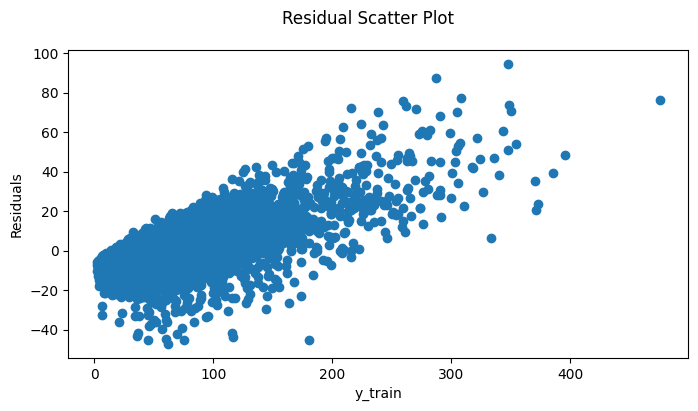

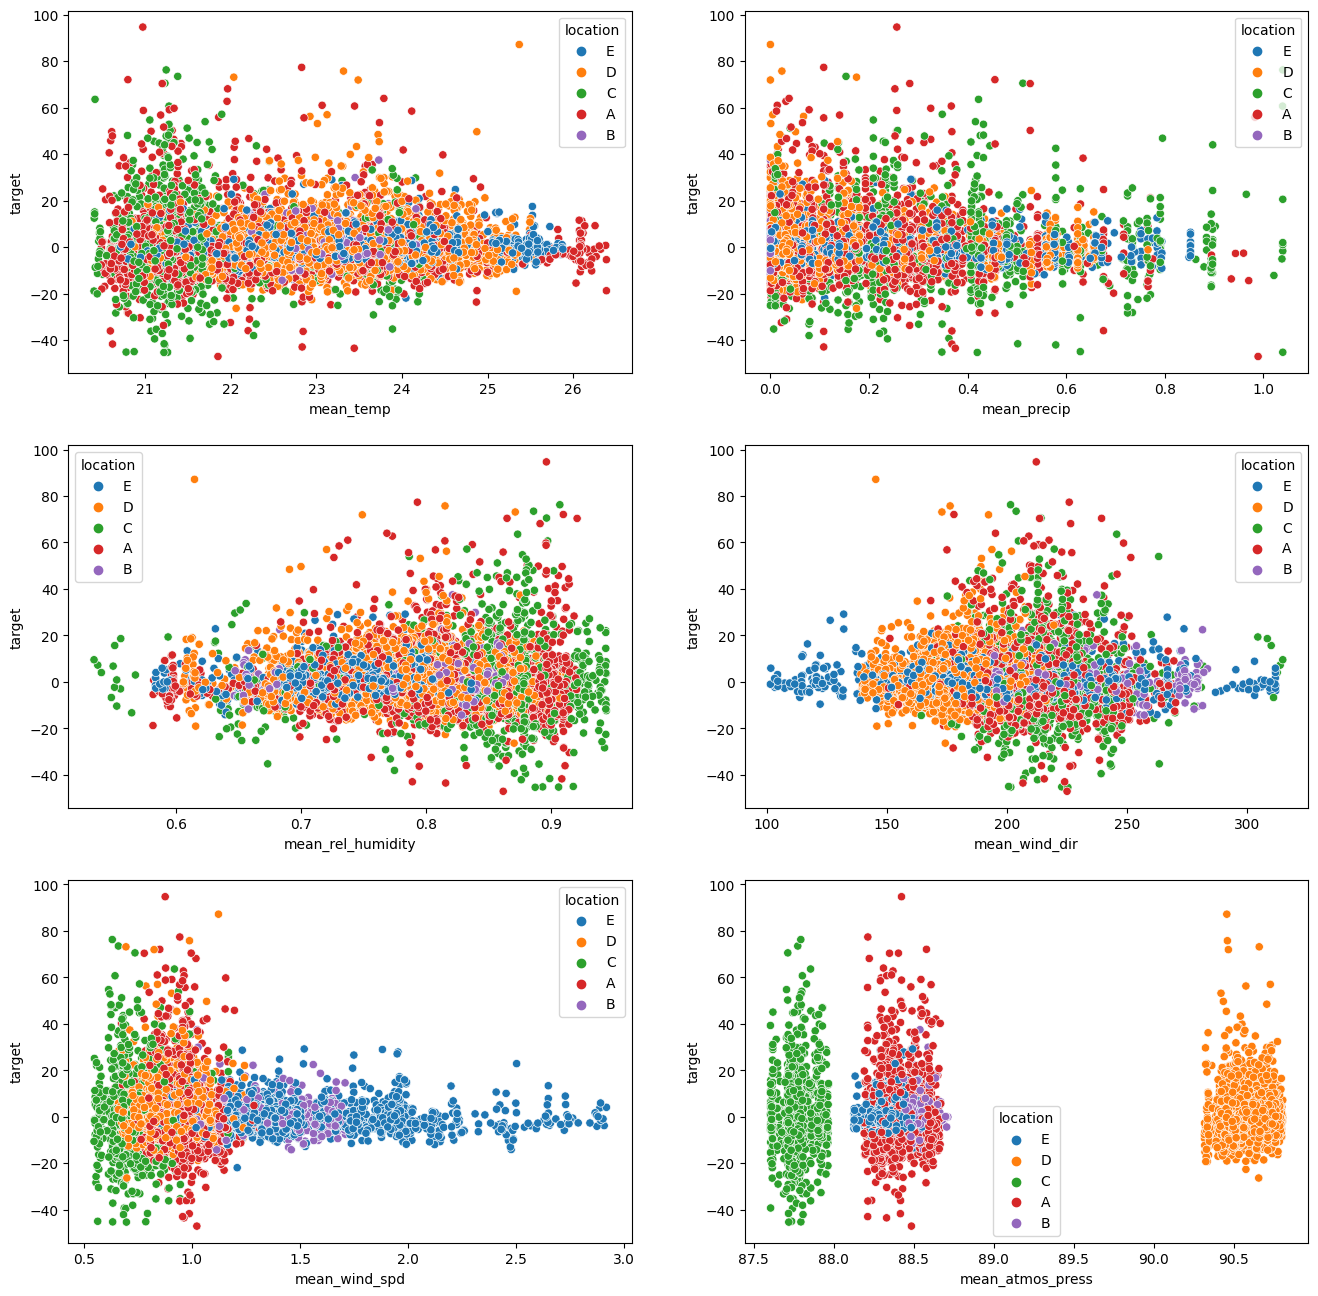

In [24]:
#calculate residuals
residuals=y_train-y_train_pred_rf

# plot residuals
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(y_train, residuals)
ax.set_ylabel("Residuals")
ax.set_xlabel("y_train")
fig.suptitle('Residual Scatter Plot')
plt.show()

fig,ax = plt.subplots(3,2,figsize=(16,16))
count=0
for feat in baseline_features:
    sns.scatterplot(x=X_train[feat], y=residuals, hue=X_train.location,
                    ax=ax[int(count/2)][count%2])
    count += 1
